In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# generate a phase diagram for a toy system using polyphase parallel compute tool
import polyphase as phase
import numpy as np

M = [5,5,1]
chi = [1, 0.5, 0.5]
f = lambda x : phase.flory_huggins(x, M, chi)
engine = phase.PHASE(f,200,3)
engine.compute(use_parallel=False, verbose=True, lift_label=True)

3-dimensional grid generated at 0.32s
Energy computed at 3.11s
Making energy manifold a paraboloid with 2x padding of 0.11 maximum energy
Energy is corrected at 5.27s
Convexhull is computed at 5.32s
Simplices are refined at 5.83s
Total of 9599 simplices in the convex hull
Using 1.01E-01 as a threshold for Laplacian of a simplex
Simplices are labelled at 10.49s
Labels are lifted at 19.64s
Total 0/9599 coplanar simplices
Computation took 19.90s


In [5]:
# to make use of the parallel computation pipeline
engine.compute(use_parallel=True, verbose=True, lift_label=True)

2021-03-03 11:58:59,876	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265


3-dimensional grid generated at 0.34s
Energy computed at 4.15s
Making energy manifold a paraboloid with 2x padding of 0.11 maximum energy
Energy is corrected at 21.14s
Convexhull is computed at 21.20s
Using 1.01E-01 as a threshold for Laplacian of a simplex
Total of 9599 simplices in the convex hull
Simplices are refined at 24.24s
Simplices are labelled at 27.29s
Labels are lifted at 31.00s
Total 0/9599 coplanar simplices
Computation took 31.30s


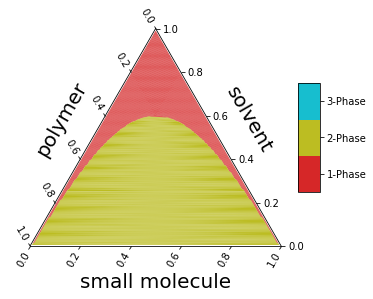

In [6]:
import matplotlib.pyplot as plt

phase.plot_mpltern(engine.grid, engine.simplices, engine.num_comps)
plt.show()

In [8]:
# We can also compute phase splits given a composition using the following
boundary_points = np.asarray([engine.is_boundary_point(x) for x in engine.grid.T])
no_boundary_grid = np.where(~boundary_points)[0]
point = engine.grid[:,np.random.choice(no_boundary_grid)]
print(point)
engine(point)

[0.36683418 0.50753769 0.12060302]


(array([4.17647059e-01, 5.82352941e-01, 2.22044605e-16]),
 array([[0.86432161, 0.01005026, 0.13065328],
        [0.01005026, 0.86432161, 0.13065328],
        [0.01507539, 0.85427136, 0.1356784 ]]),
 2)

/projects/academic/olgawodo/kiranvad/Projects/Spring2020/PhaseModelling/polyphase/utils.py:62: RuntimeWarning: invalid value encountered in log
  T1 += (xi*np.log(xi))/M[i] + beta/xi


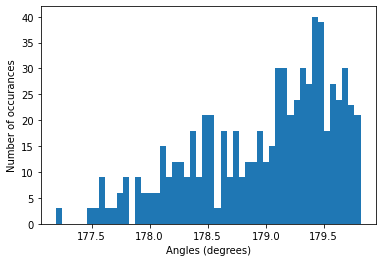

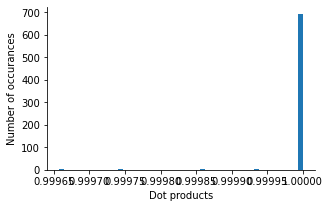

In [10]:
# performing tangent normal test
gradient = phase.CentralDifference(engine.grid, f)  
phase_simplices_ids = np.where(np.asarray(engine.num_comps)==2)[0]
outlist = []
for simplex_id in phase_simplices_ids:
    test = phase.TestAngles(engine,phase=2,simplex_id=simplex_id)
    test_out = test.get_angles(gradient)
    for _, value in test_out['thetas'].items():
        outlist.append([value[2], value[3]])

outlist = np.asarray(outlist)        
assert len(outlist)==len(phase_simplices_ids)*3    
fig, ax = plt.subplots()
ax.hist(outlist[:,0],bins=50, density=False)
ax.set_xlabel('Angles (degrees)')
ax.set_ylabel('Number of occurances')

fig, ax = plt.subplots()
ax.hist(outlist[:,1],bins=50, density=False)
ax.set_xlabel('Dot products')
ax.set_ylabel('Number of occurances')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [12]:
# Perform phase splitting test
PHASE_ID = 2
phase_simplices_ids = np.where(np.asarray(engine.num_comps)==PHASE_ID)[0]
failed = []
criteria = engine.df.T['label']==PHASE_ID
lengths = []
for simplex_id in phase_simplices_ids:
    test = phase.TestPhaseSplits(engine,phase=PHASE_ID,simplex_id=simplex_id, threshold=0.05)
    if not test.check_centroid():
        failed.append(simplex_id)

print('{}/{} simplices failed the test'.format(len(failed), len(phase_simplices_ids)))

1/235 simplices failed the test
